# Utility Functions

# Read Data

In [2]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import os
from typing import List, Set, Dict, Tuple
from utils import get_conn, query_aws, PROJ_DIR, TREE, V_CODE
import tqdm
import spacy
from itertools import chain
from collections import Counter
import torch
import math
import re
pd.set_option('display.max_colwidth', -1)
nlp = spacy.load("en_core_web_sm")

In [3]:
# read in list of all notes
notes_df = query_aws("select text from mimiciii.noteevents limit 50000")
notes = notes_df["text"].tolist()

In [4]:
# set data locations
datadir = os.path.join(PROJ_DIR, "data", "preprocessed")
imagedir = os.path.join(PROJ_DIR, "data", "images")
modeldir = os.path.join(PROJ_DIR, "data", "models")

# load all processed data (with embeddings excluded)
df = pd.read_pickle(os.path.join(datadir, "visdata.pd"))

# load test data
test_df = pd.read_pickle(os.path.join(datadir, "test.pd"))
Y_test = test_df["roots"].tolist()
class_names = pd.read_csv(os.path.join(datadir, "class_names.csv"), 
                          header=None, squeeze=True).tolist()

In [5]:
# add root names to df
get_codes = lambda dummies: [class_names[i] for i, dum in enumerate(dummies) if dum]
df["root_names"] = df["roots"].apply(get_codes)

# Exploratory Visualizations

In [5]:
from scripts.visdata import summary_table, note_lengths, icd_summary
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Summary Tables

In [32]:
# load summary table data
summ_df = summary_table(query_aws)
row_order = ["Patients", "Admissions", "ICD9 Codes", "Deaths"]
col_order = ["Totals", "Male", "Female", "Private", "Medicare", "Medicaid", "Government", "Self Pay"]
summ_df = summ_df.loc[row_order, col_order]

/Users/cccdenhart/Documents/projects/icd_tagging/scripts/visdata.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  summary_df = pd.concat([totals_df, gender_df, insurance_df], axis=0)


In [39]:
summ_df

Category,Totals,Male,Female,Private,Medicare,Medicaid,Government,Self Pay
Patients,46520,26121,20399,19663,21002,4570,1614,600
Admissions,58976,32950,26026,22582,28215,5785,1783,611
ICD9 Codes,11501,5852,5649,5718,5023,3989,2657,1467
Deaths,5836,3141,2695,1372,3903,381,90,95


In [15]:
all_roots = list(it.chain.from_iterable(df["root_names"].tolist()))
icd_table = icd_summary(all_roots, TREE)

In [20]:
icd_table

,Code,Mimic-iii Counts,Number of Leaves,Description
0,001-139,173037,871,INFECTIOUS AND PARASITIC DISEASES
1,140-239,56220,660,NEOPLASMS
2,240-279,256828,278,"ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS"
3,280-289,0,10,DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS
4,290-319,106277,307,MENTAL DISORDERS
5,320-389,153848,1334,DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS
6,390-459,334785,403,DISEASES OF THE CIRCULATORY SYSTEM
7,460-519,269565,217,DISEASES OF THE RESPIRATORY SYSTEM
8,520-579,192481,519,DISEASES OF THE DIGESTIVE SYSTEM
9,580-629,213352,382,DISEASES OF THE GENITOURINARY SYSTEM


## Categories

In [22]:
query = "select category, count(row_id) from mimiciii.noteevents group by category;"
ccounts_df = query_aws(query)
ccounts_df.columns = ["Category", "Count"]
ccounts_df = ccounts_df.sort_values("Count", ascending=False)

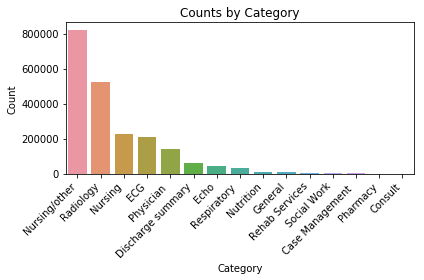

In [42]:
cat_fp = os.path.join(imagedir, "categories.png")
ax = sns.barplot(x="Category", y="Count", data=ccounts_df)
ax.set_title("Counts by Category")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.savefig(cat_fp)
plt.show()

## Distributions

In [63]:
icd_lens = [len(r) for r in df["root_names"].tolist()]
note_lens = notes_df["text"].apply(lambda s: len(re.findall(r'\w+', s)))
note_lens_mid = lens[lens.between(lens.quantile(.1), lens.quantile(.9))]

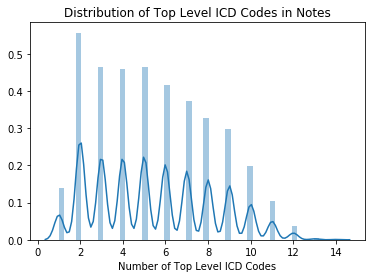

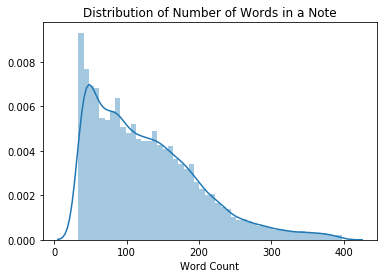

In [69]:
ax = sns.distplot(icd_lens)
ax.set(xlabel="Number of Top Level ICD Codes",
       title="Distribution of Top Level ICD Codes in Notes")
plt.savefig(os.path.join(imagedir, "num_icd_codes.png"))
plt.show()

ax = sns.distplot(note_lens_mid)
ax.set_title("Distribution of Number of Words in a Note")
ax.set_xlabel("Word Count")
plt.savefig(os.path.join(imagedir, "word_counts.png"))

plt.show()

## ICD Codes by Insurance

In [60]:
# read data
query = """
SELECT admissions.hadm_id AS adm_id, count(diagnoses_icd.icd9_code) AS icd, array_agg(admissions.insurance)[1] AS insurance
FROM mimiciii.admissions AS admissions
JOIN mimiciii.diagnoses_icd AS diagnoses_icd
ON admissions.hadm_id = diagnoses_icd.hadm_id
GROUP BY admissions.hadm_id;
"""
insur_icd_df = query_aws(query)

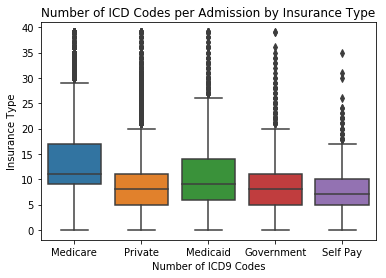

In [70]:
ax = sns.boxplot(x="insurance", y="icd", data=insur_icd_df)
ax.set(xlabel="Number of ICD9 Codes",
       ylabel="Insurance Type",
       title="Number of ICD Codes per Admission by Insurance Type")
plt.savefig(os.path.join(imagedir, "insurance.png"))
plt.show()

## Word Cloud

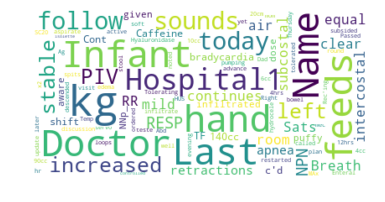

In [76]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(notes[15])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(os.path.join(imagedir, "wordcloud.png"))
plt.show()

## Embedding Comparisons

In [6]:
from gensim.models import KeyedVectors
from transformers import AutoTokenizer, AutoModel

In [7]:
# load word2vec
w2v_fp = os.path.join(PROJ_DIR, "data", "embeddings", 
                      "GoogleNews-vectors-negative300.bin")
word2vec = KeyedVectors.load_word2vec_format(w2v_fp, binary=True)

# load bert
bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
bert.eval()
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [86]:
from torch.nn.utils.rnn import pad_sequence

In [85]:
T = [torch.tensor(tokenizer.encode(n, add_special_tokens=True)) for n in notes[0:31]]

In [87]:
pX = pad_sequence(T)

In [88]:
e = bert(pX)

# Results

In [8]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from transformers import BertModel

In [15]:
class Lstm(nn.Module):
    """An LSTM implementation with sklearn-like methods."""

    def __init__(self, weights):
        super(Lstm, self).__init__()
        # instance variables
        self.n_code: int = 16
        self.lstm_size: int = 128
        self.batch_size: int = 64
        self.n_epochs: int = 30
        if isinstance(weights, BertModel):
            self.embeddings = weights
            self.embedding_dim: int = 768

        else:
            self.embeddings = nn.Embedding.from_pretrained(weights)
            self.embedding_dim: int = 300

        self.lstm = nn.LSTM(self.embedding_dim, self.lstm_size)
        self.hidden2code = nn.Linear(self.lstm_size, self.n_code)

    def forward(self, X: List[List[int]]) -> torch.tensor:
        # zero pad sequences such that all are length of longest seq
        seq_lens = torch.Tensor([len(seq) for seq in X])
        X = [torch.LongTensor(samp) for samp in X]
        try:
            pad_X = pad_sequence(X)
        except:
            breakpoint()

        # get embeddings
        embeds = self.embeddings(pad_X)
        if isinstance(self.embeddings, BertModel):
            embeds = embeds[0]

        # pack padded sequences
        pack_X = pack_padded_sequence(embeds, seq_lens, enforce_sorted=False)

        # propagate through network
        _, (h_n, _) = self.lstm(pack_X)
        code_space = self.hidden2code(h_n)
        code_scores = torch.sigmoid(code_space).squeeze()
        return code_scores

    def fit(self, X: List[List[int]], Y: List[List[int]]):
        """Train network on training set."""
        # initialize batcher
        dataset = ICDDataset(X, Y)
        batcher = Batcher(dataset, batch_size=self.batch_size)

        # initialize parameters
        self.train()  # set model to train mode
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

        # propagate through network
        print("Training LSTM .....")
        for i in range(self.n_epochs):
            print(f"\tEpoch {i}:", end=" ")
            for X_batch, Y_batch in batcher:

                # zero the parameter gradients
                self.zero_grad()

                # retrieve outputs
                outputs = self.forward(X_batch)

                # determine loss and backprop
                loss = loss_fn(outputs, Y_batch)
                loss.backward()  # calculate gradients
                optimizer.step()  # update parameters

            print(f"loss = {loss}")
        print("done.")
        return self

    def predict(self, X: List[List[int]], threshold: float = 0.5) -> np.ndarray:
        """Give predictions for the given data."""
        probs = self(X)
        pos = torch.where(probs < threshold, probs, torch.ones(*probs.shape))
        neg = torch.where(pos > threshold, pos, torch.zeros(*probs.shape))
        preds = neg.long().numpy()
        return preds

    def predict_proba(self, X: List[List[int]]) -> np.ndarray:
        """Get probabilities for the given data."""
        return self(X).detach().numpy()

## Load Classifiers

In [10]:
import joblib
from scripts.models import Clf, Lstm
from sklearn.base import BaseEstimator
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             classification_report)
from scripts.evaluation import ml_accuracy, probs_to_preds

In [8]:
# load base classifiers
clf_fns = ["LogisticRegression.sk", "RandomForest.sk", "MLP.sk"]
clfs = [Clf(joblib.load(os.path.join(modeldir, fn)), fn.split(".")[0]) 
        for fn in clf_fns]

In [9]:
# get predictionss for each clf
for clf in clfs:
    clf.set_preds(test_df["d2v"].tolist())
    clf.set_probs(test_df["d2v"].tolist())

In [95]:
samp = Lstm(torch.tensor(word2vec.vectors))

In [16]:
# load lstms
lstm_w2v_fn = "Lstm_w2v1.pt"
lstm_w2v = Lstm(torch.tensor(word2vec.vectors))
lstm_w2v.load_state_dict(torch.load(os.path.join(modeldir, lstm_w2v_fn)))
lstm_w2v.eval()

Lstm(
  (embeddings): Embedding(3000000, 300)
  (lstm): LSTM(300, 128)
  (hidden2code): Linear(in_features=128, out_features=16, bias=True)
)

In [ ]:
clf = Clf(lstm_w2v, "Lstm_w2v")
clf.set_preds(test_df["w2v_idx"].tolist())
clf.set_probs(test_df["w2v_idx"].tolist())

## Performance Results

In [15]:
# get performance data
f1s = [f1_score(Y_test, clf.preds, average="weighted", zero_division=1) for clf in clfs]
accs = [ml_accuracy(Y_test, clf.preds) for vals in clfs]
precs = [precision_score(Y_test, clf.preds, average="weighted", zero_division=1) for clf in clfs]
recs = [recall_score(Y_test, clf.preds, average="weighted", zero_division=1) for clf in clfs]
metrics = f1s + accs + precs + recs
met_labels = ["F1 Score"] * len(clfs) + ["Accuracy"] * len(clfs)\
             + ["Precision"] * len(clfs) + ["Recall"] * len(clfs)
clf_names = [clf.name for clf in clfs] * 4

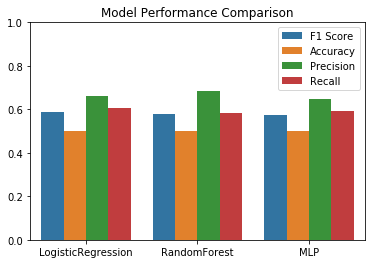

In [18]:
ax = sns.barplot(x=clf_names, y=metrics, hue=met_labels)
ax.set_ylim([0, 1])
ax.set(title="Model Performance Comparison")
plt.savefig("data/images/model_comparison.png")
plt.show()

## Classification Reports

In [25]:
class_reports = {clf.name: classification_report(Y_test, clf.preds, target_names=class_names, 
                                             zero_division=1, output_dict=True)
                 for clf in clfs}
crep_dfs = {name: pd.DataFrame(crep).T for name, crep in class_reports.items()}
crep_df = pd.concat(crep_dfs, axis=1)

In [26]:
crep_df

LogisticRegression                                    MLP  \
                       f1-score precision    recall  support  f1-score   
001-139                0.482014  0.626559  0.391660   5132.0  0.419342   
140-239                0.061664  0.757143  0.032141   1649.0  0.000000   
240-279                0.747290  0.665605  0.851828   7606.0  0.765780   
290-319                0.062518  0.516588  0.033272   3276.0  0.009042   
320-389                0.119231  0.522766  0.067289   4607.0  0.016201   
390-459                0.897409  0.840118  0.963085  10050.0  0.900535   
460-519                0.787083  0.730631  0.852988   8115.0  0.754017   
520-579                0.484314  0.615959  0.399032   5784.0  0.434725   
580-629                0.653559  0.629736  0.679254   6435.0  0.632984   
630-679                0.000000  1.000000  0.000000      1.0  0.000000   
680-709                0.007916  0.529412  0.003988   2257.0  0.005277   
710-739                0.008193  0.320000  0.004149   1928.0  0.000000   
760-779                0.931186  0.957214  0.906537   3381.0  0.951055   
780-799                0.520266  0.607055  0.455189   5936.0  0.514468   
800-999                0.658786  0.621687  0.700594   6563.0  0.652676   
V01-V91                0.693785  0.639446  0.758217   8458.0  0.718414   
micro avg              0.646073  0.694374  0.604055  81178.0  0.640014   
macro avg              0.444701  0.661245  0.443701  81178.0  0.423407   
weighted avg           0.589918  0.662198  0.604055  81178.0  0.572556   
samples avg            0.633812  0.716186  0.632514  81178.0  0.629854   

                                          RandomForest                      \
             precision    recall  support     f1-score precision    recall   
001-139       0.662737  0.306703   5132.0     0.422949  0.670758  0.308846   
140-239       1.000000  0.000000   1649.0     0.028520  0.705882  0.014554   
240-279       0.651276  0.929135   7606.0     0.743214  0.677863  0.822509   
290-319       0.357143  0.004579   3276.0     0.065698  0.689024  0.034493   
320-389       0.452381  0.008248   4607.0     0.173524  0.609948  0.101150   
390-459       0.845308  0.963483  10050.0     0.894023  0.833161  0.964478   
460-519       0.784497  0.725816   8115.0     0.788375  0.723658  0.865804   
520-579       0.604558  0.339385   5784.0     0.444220  0.631898  0.342497   
580-629       0.632248  0.633722   6435.0     0.632328  0.651450  0.614297   
630-679       1.000000  0.000000      1.0     0.000000  1.000000  0.000000   
680-709       0.352941  0.002658   2257.0     0.008787  0.526316  0.004431   
710-739       0.000000  0.000000   1928.0     0.007191  0.368421  0.003631   
760-779       0.942492  0.959775   3381.0     0.915143  0.970179  0.866016   
780-799       0.627760  0.435815   5936.0     0.494229  0.636412  0.403976   
800-999       0.627443  0.680024   6563.0     0.643206  0.634947  0.651684   
V01-V91       0.608892  0.875975   8458.0     0.701917  0.644453  0.770631   
micro avg     0.697176  0.591515  81178.0     0.638518  0.707386  0.581869   
macro avg     0.634355  0.429082  81178.0     0.435208  0.685898  0.423062   
weighted avg  0.648737  0.591515  81178.0     0.580525  0.683649  0.581869   
samples avg   0.714509  0.619924  81178.0     0.623691  0.720869  0.607721   

                       
              support  
001-139        5132.0  
140-239        1649.0  
240-279        7606.0  
290-319        3276.0  
320-389        4607.0  
390-459       10050.0  
460-519        8115.0  
520-579        5784.0  
580-629        6435.0  
630-679           1.0  
680-709        2257.0  
710-739        1928.0  
760-779        3381.0  
780-799        5936.0  
800-999        6563.0  
V01-V91        8458.0  
micro avg     81178.0  
macro avg     81178.0  
weighted avg  81178.0  
samples avg   81178.0

## Probability Distributions

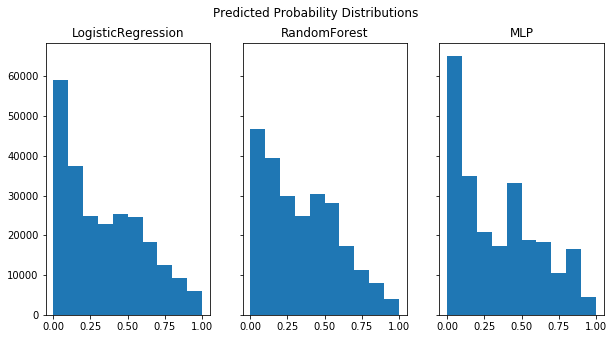

In [28]:
fig, axs = plt.subplots(1, len(clfs), sharey="all", sharex="all")
for ax, clf in zip(axs, clfs):
    ax.hist(clf.probs.flatten())
    ax.set(title=clf.name)
fig.set_size_inches(10, 5)
fig.suptitle("Predicted Probability Distributions")
plt.savefig("data/images/prob_dists.png")
plt.show()

## Precision/Recall Curves

In [36]:
def pr_curve(clf_name, probs, y_true, thresholds):
    """
    Generate precision/recall curve data for a given classifier.

    Implementation is custom because sklearn doesn't
    support multilabel classification for pr curve.
    """
    precs = []
    recs = []
    for thresh in tqdm.tqdm(thresholds):
        preds = probs_to_preds(probs, thresh)
        precs.append(precision_score(y_true, preds, average="weighted", zero_division=1))
        recs.append(recall_score(y_true, preds, average="weighted", zero_division=1))
    data = {"Classifier": [clf_name] * len(thresholds),
            "Precision": precs, 
            "Recall": recs, 
            "Threshold": thresholds}
    return pd.DataFrame(data)

In [38]:
# extract precision/recall data across thresholds
thresholds = np.linspace(0, 1, 10)
pr_dfs = [pr_curve(clf.name, clf.probs, Y_test, thresholds) for clf in clfs]
pr_df = pd.concat(pr_dfs)

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


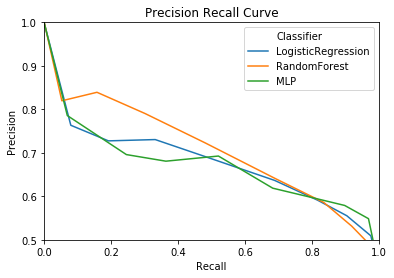

In [40]:
# plot precision recall curve for each classifier
ax = sns.lineplot(x="Recall", y="Precision", hue="Classifier", data=pr_df)
ax.set_ylim([0.5, 1])
ax.set_xlim([0, 1])
ax.set(title="Precision Recall Curve")
plt.savefig("data/images/prec_rec.png")
plt.show()

## Category Performance